In [1]:
%matplotlib inline

import torch
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
from laughter_classification.sspnet_data_sampler import SSPNetDataSampler
from laughter_prediction.feature_extractors import LibrosaExtractor
from sklearn.model_selection import train_test_split
from laughter_prediction.rnn import LibrosaFeaturesRnn

In [2]:
!mkdir -p data

In [3]:
directory = 'vocalizationcorpus/data'
audio_files = list(sorted(os.listdir('vocalizationcorpus/data')))

audio_file = directory + '/' + audio_files[0]
audio_file

'vocalizationcorpus/data/S0001.wav'

(128, 474)


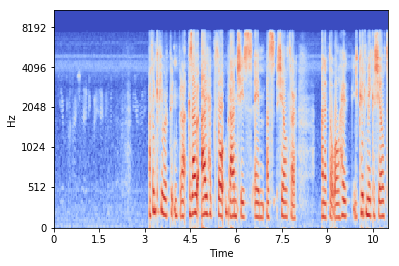

In [4]:
y, sr = librosa.load(audio_file)
S = librosa.feature.melspectrogram(y, sr)
S = librosa.power_to_db(S)

print(S.shape)
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel')

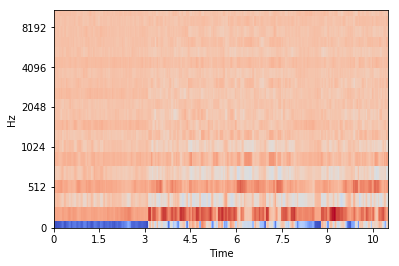

In [5]:
y, sr = librosa.load(audio_file)
S = librosa.feature.mfcc(y, sr)
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel')

In [6]:
extractor = LibrosaExtractor()
extractor.extract_features(audio_file).head()

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_010,mfcc_011,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019
0,-14.770546,-7.502573,-14.677981,-10.937127,-21.269282,-39.300535,-43.299913,-38.613908,-20.862417,-16.210959,...,7.274429,11.029847,10.672556,-0.565825,19.375721,1.419888,6.978270,-2.037510,20.511622,8.859711
1,-16.770523,-8.677541,-18.883031,-33.635306,-29.146382,-23.314792,-15.536017,-10.014064,-25.719489,-35.669000,...,-16.901669,-7.184055,-19.194132,-17.970590,12.663122,-0.107084,20.268938,1.372494,-7.076095,8.931564
2,-12.352719,-4.444362,-14.673733,-42.556730,-17.731121,-11.759801,-19.046962,-15.194353,-23.255466,-19.323618,...,-11.666725,2.564224,-4.208590,-11.211039,16.965807,16.649665,23.453795,11.212921,9.460361,-13.224893
3,-15.440580,-7.917505,-18.145880,-45.599949,-29.652522,-23.691098,-19.468875,-14.010716,-25.302332,-22.604453,...,-0.191644,9.514174,-7.796018,-7.132752,11.623116,8.058064,21.677039,-1.138147,-2.169490,-5.259990
4,-18.958624,-11.360067,-18.807546,-15.593530,-23.763246,-21.985535,-24.705120,-19.680730,-22.500579,-18.102045,...,-14.405206,-4.518877,4.056877,6.588490,14.185785,-15.692512,3.539914,12.142542,9.761851,3.887359


In [7]:
SAMPLE_RATE = 16000
FRAME_SEC = 0.3

In [8]:
sampler = SSPNetDataSampler('vocalizationcorpus')

In [9]:
data = sampler.create_sampled_df(FRAME_SEC, save_path='data/sampled.csv')

/home/maxim/PycharmProjects/speech-ml-hw/2/homework/laughter_classification/sspnet_data_sampler.py:111: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  return pd.DataFrame.from_csv(save_path, index_col=None)


In [10]:
data

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019,IS_LAUGHTER,SNAME
0,-1.822273,-4.153107,-6.127165,-4.744270,-3.042214,-1.339390,3.440107,12.049357,18.508058,18.495235,...,-3.279198,-7.744685,13.188406,-15.828284,-2.788314,-6.735201,-0.648314,-2.205029,0,S0883
1,-15.560526,-12.192421,-17.653885,-19.870362,-14.625828,-18.043698,-17.459772,-15.043800,-15.155906,-14.942318,...,2.968277,-3.823424,7.782831,-10.649842,12.054846,-16.101373,7.706882,7.032740,0,S0883
2,-13.402336,-9.324762,-11.337922,-13.557925,-11.274661,-11.788429,-12.618071,-13.004464,-12.791547,-12.865611,...,10.503806,-3.110308,16.844341,-16.793098,9.245858,-12.490855,1.376820,-1.481758,0,S0883
3,-15.991697,-11.128731,-14.647389,-14.145352,-10.337301,-8.605968,-6.843310,-8.546107,-9.693120,-10.963831,...,15.545574,-3.590542,14.474457,-15.913445,2.790456,-15.866880,-1.439778,-4.094808,0,S0883
4,-16.955938,-13.346069,-15.512038,-17.894600,-18.070054,-17.828938,-16.749832,-16.722315,-19.911563,-19.673532,...,5.920388,-4.687736,15.792177,-13.221612,13.721047,-13.489680,9.807748,-2.527528,0,S0883
5,0.646691,-5.498471,-6.820034,-8.193006,-7.084161,-3.792549,-1.219193,11.592491,17.865859,15.925368,...,-2.049894,-14.379304,3.403395,-12.829240,2.768446,-5.736103,3.966473,0.461561,0,S0883
6,-6.284641,-4.476452,-4.508171,-5.953777,-6.800229,-4.671392,-0.456830,3.798520,3.489447,4.283108,...,7.559780,-1.081865,0.940473,-14.494771,1.262333,-2.956683,-4.423065,3.032808,0,S0883
7,-15.978457,-12.014055,-19.023314,-23.477487,-19.386470,-20.043930,-20.530321,-19.775818,-20.583855,-20.342087,...,12.887851,-2.703269,14.150279,-16.079925,19.098814,-9.557634,4.102285,-1.883761,0,S0883
8,-16.920980,-13.219841,-16.037795,-18.457891,-18.815624,-15.650121,-14.958242,-15.178341,-16.562365,-18.883285,...,1.705320,-2.482357,11.217743,-20.793836,9.347085,-12.347605,10.098329,-2.900409,0,S0883
9,-15.483795,-11.250385,-14.363998,-15.435853,-15.122773,-16.479205,-16.355765,-15.626713,-14.124518,-13.873653,...,9.564394,-11.874891,9.189812,-19.225750,9.891422,-9.940770,13.255929,-2.335170,0,S0883


In [11]:
sampler_noisy = SSPNetDataSampler('vocalizationcorpus')
data_noisy = sampler_noisy.create_sampled_df(FRAME_SEC, save_path='data/sampled_noisy.csv')

In [12]:
data_noisy

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019,IS_LAUGHTER,SNAME
0,-1.822273,-4.153107,-6.127165,-4.744270,-3.042214,-1.339390,3.440107,12.049357,18.508058,18.495235,...,-3.279198,-7.744685,13.188406,-15.828284,-2.788314,-6.735201,-0.648314,-2.205029,0,S0883
1,-15.560526,-12.192421,-17.653885,-19.870362,-14.625828,-18.043698,-17.459772,-15.043800,-15.155906,-14.942318,...,2.968277,-3.823424,7.782831,-10.649842,12.054846,-16.101373,7.706882,7.032740,0,S0883
2,-13.402336,-9.324762,-11.337922,-13.557925,-11.274661,-11.788429,-12.618071,-13.004464,-12.791547,-12.865611,...,10.503806,-3.110308,16.844341,-16.793098,9.245858,-12.490855,1.376820,-1.481758,0,S0883
3,-15.991697,-11.128731,-14.647389,-14.145352,-10.337301,-8.605968,-6.843310,-8.546107,-9.693120,-10.963831,...,15.545574,-3.590542,14.474457,-15.913445,2.790456,-15.866880,-1.439778,-4.094808,0,S0883
4,-16.955938,-13.346069,-15.512038,-17.894600,-18.070054,-17.828938,-16.749832,-16.722315,-19.911563,-19.673532,...,5.920388,-4.687736,15.792177,-13.221612,13.721047,-13.489680,9.807748,-2.527528,0,S0883
5,0.646691,-5.498471,-6.820034,-8.193006,-7.084161,-3.792549,-1.219193,11.592491,17.865859,15.925368,...,-2.049894,-14.379304,3.403395,-12.829240,2.768446,-5.736103,3.966473,0.461561,0,S0883
6,-6.284641,-4.476452,-4.508171,-5.953777,-6.800229,-4.671392,-0.456830,3.798520,3.489447,4.283108,...,7.559780,-1.081865,0.940473,-14.494771,1.262333,-2.956683,-4.423065,3.032808,0,S0883
7,-15.978457,-12.014055,-19.023314,-23.477487,-19.386470,-20.043930,-20.530321,-19.775818,-20.583855,-20.342087,...,12.887851,-2.703269,14.150279,-16.079925,19.098814,-9.557634,4.102285,-1.883761,0,S0883
8,-16.920980,-13.219841,-16.037795,-18.457891,-18.815624,-15.650121,-14.958242,-15.178341,-16.562365,-18.883285,...,1.705320,-2.482357,11.217743,-20.793836,9.347085,-12.347605,10.098329,-2.900409,0,S0883
9,-15.483795,-11.250385,-14.363998,-15.435853,-15.122773,-16.479205,-16.355765,-15.626713,-14.124518,-13.873653,...,9.564394,-11.874891,9.189812,-19.225750,9.891422,-9.940770,13.255929,-2.335170,0,S0883


In [105]:
def split(df, test_size=0.2, seed=0):
    np.random.seed(seed)
    df.sort_values('SNAME')
    df_by_sname = df.groupby('SNAME')
    
    records = [record for _, record in df_by_sname]
    snames  = [sname  for sname, _ in df_by_sname]
    y = [record['IS_LAUGHTER'] for record in records]
    X = [record.drop(['IS_LAUGHTER', 'SNAME'], axis=1) for record in records]
    
    y = np.array(y)
    X = np.array([x_df.values for x_df in X], dtype=np.float)
    
    X_train, X_test, y_train, y_test, snames_train, snames_test = \
        train_test_split(X, y, snames, train_size=1. - test_size, test_size=0.2)
    return  X_train, X_test, y_train, y_test, snames_train, snames_test

In [106]:
X_train, X_test, y_train, y_test, snames_train, snames_test = split(data)

Int64Index([35064, 35065, 35066, 35067, 35068, 35069, 35070, 35071, 35072,
            35073, 35074, 35075, 35076, 35077, 35078, 35079, 35080, 35081,
            35082, 35083, 35084, 35085, 35086, 35087, 35088, 35089, 35090,
            35091, 35092, 35093, 35094, 35095, 35096, 35097, 35098, 35099],
           dtype='int64')


In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [16]:
print(y_train[0], snames_train[0])

pd.DataFrame(X_train[0], columns=data.columns[:-2])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0] S2699


,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_010,mfcc_011,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019
0,6.257164,3.361763,2.671048,5.010182,9.478846,20.287347,21.990934,14.007866,4.607846,4.329974,...,-1.013170,-12.085245,-1.407973,-14.278140,16.429393,-9.807446,1.837828,-13.528439,8.220285,-3.875397
1,-9.967453,-4.676869,-0.192405,0.194319,-2.111504,2.691181,3.706375,2.016098,3.156487,1.982790,...,-1.225641,-19.375396,-2.177219,-12.464066,12.545731,-11.025590,3.820312,-8.562596,6.104540,-8.573751
2,-3.754772,-3.121617,-0.566127,1.311469,13.584241,17.617087,15.264530,9.067810,5.948613,4.995819,...,-7.133327,-13.249756,-3.210758,-13.853175,6.981013,-13.378003,-1.329492,-9.908009,0.616688,-5.560148
3,8.223982,3.632526,3.555822,10.648567,24.231825,25.982805,17.637700,14.832560,13.507589,16.061658,...,-8.075076,-8.639950,2.695211,-18.312387,10.066080,-9.149796,2.840441,-11.263851,-0.123179,-4.138264
4,-0.418774,-0.336081,-0.718594,5.093183,10.486602,8.104830,2.908852,1.421486,0.012385,3.740209,...,-4.008566,-11.523667,5.737783,-5.672441,11.173043,-8.489029,0.503631,-5.861201,-3.588013,-4.273097
5,-14.300288,-10.712865,-10.532799,-10.291429,-10.626286,-12.952157,-13.163009,-11.939524,-10.205115,-12.483380,...,-7.606938,-13.534336,10.778629,-7.330040,19.068362,-13.748308,11.687143,-11.386086,5.329266,-1.116598
6,-19.927612,-18.025792,-12.980354,-11.464269,-14.693332,-15.337453,-12.754700,-14.145948,-15.947249,-17.635436,...,-3.582243,-11.814760,3.586220,-10.044034,20.492682,-11.187516,8.485057,-12.775483,4.927253,-3.247170
7,-22.373778,-16.771126,-17.234851,-16.212042,-17.591307,-17.411768,-16.304863,-19.700920,-20.006163,-19.338484,...,0.999712,-7.988750,3.041116,-14.743590,18.343244,-13.827879,14.927122,-11.012321,7.535574,-3.542544
8,-19.969246,-15.146829,-12.898381,-10.592601,-13.427900,-16.746509,-16.798632,-19.003511,-18.028235,-18.716435,...,-0.817591,0.053075,12.908929,-11.479326,13.690501,-14.292013,13.881425,-9.006013,4.604711,-4.569124
9,-18.125744,-13.414346,-10.011019,-11.064839,-12.427063,-11.417509,-10.497217,-13.001850,-14.711519,-15.375097,...,0.509145,-3.161676,-2.549224,-15.685902,16.617105,-9.404347,5.574549,-12.794296,2.638883,-2.479722


In [17]:
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy, snames_train_noisy, snames_test_noisy = split(data_noisy)

In [18]:
snames_test_noisy == snames_test

True

In [19]:
torch.zeros(2,2,2)

tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]])

In [251]:
fbank_features = sum(1 for col in data_noisy.columns if col.startswith('fbank'))
mfcc_features = sum(1 for col in data_noisy.columns  if col.startswith('mfcc'))
hidden_size = 100
batch_size = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [252]:
fbank_features, mfcc_features, hidden_size, batch_size, device

(128, 20, 100, 1000, 'cpu')

In [253]:
Model = LibrosaFeaturesRnn(fbank_features, mfcc_features, 
                           hidden_size=hidden_size,
                           batch_size=batch_size)

In [254]:
indices = np.random.choice(X_train.shape[0], batch_size, replace=False)
cur_batch = X_train_noisy[indices]
cur_batch = torch.from_numpy(cur_batch).float()
cur_y = torch.from_numpy(y_train_noisy[indices])

In [255]:
cur_y.size()

torch.Size([1000, 36])

In [256]:
cur_batch

tensor([[[-21.4771, -12.7796, -14.6246,  ...,  -7.7220,  -1.5255,  -1.7241],
         [-22.5343, -14.7452, -14.5443,  ...,  -3.5121, -11.3527,   0.6396],
         [-16.5034, -13.7530,  -9.3910,  ...,  -7.0958,  -5.9660,  -4.4125],
         ...,
         [-12.6706,  -8.5351, -12.7664,  ...,  -2.3944, -11.5751,  -3.3221],
         [-18.1642, -10.7896, -12.8107,  ...,  -9.1776,  -1.6932,  -0.5324],
         [-17.2905, -10.3213, -13.9525,  ...,  -8.6984,   0.9381,   0.8252]],

        [[-15.8359,  -2.2474,  -5.2472,  ...,   2.0939,   0.9652,  -1.4046],
         [-13.9972,  -6.3573, -12.3353,  ...,  -2.6387,  -0.8286,   2.0090],
         [-16.4966,  -7.4004,  -9.7182,  ...,  -2.4734,  -1.2463,   0.0644],
         ...,
         [-11.8334,  -4.6528,  -9.1141,  ...,  -4.3320,  -5.5533,  -0.5983],
         [-14.6896,  -4.7361,  -6.8330,  ...,  -0.9315, -11.3759,  -1.0456],
         [-12.9109,  -4.8379,  -5.5251,  ...,  -2.7624,  -7.6651,  -2.9763]],

        [[  2.7721,  -3.3124,   7.0304,  ...

In [257]:
cur_batch.size()

torch.Size([1000, 36, 148])

In [258]:
cur_batch[:, :, :fbank_features].permute(1, 0, 2).size()


torch.Size([36, 1000, 128])

In [259]:
type(cur_batch)

torch.Tensor

In [260]:
a, b = Model.forward(cur_batch)
a.size(), b.size()

torch.Size([36, 1000, 128])
torch.Size([36, 1000, 20])


(torch.Size([36, 1000, 2]), torch.Size([36, 1000, 2]))

In [261]:
positive_fraction = np.average(y_train == 1)

In [262]:
cur_y = cur_y.transpose(0, 1)

In [263]:
cur_y = cur_y.long()

In [264]:
import torch.nn.functional as F

In [265]:
Model = LibrosaFeaturesRnn(fbank_features, mfcc_features, 
                           hidden_size=hidden_size,
                           batch_size=batch_size)

In [266]:
optimizer = torch.optim.Adam(Model.parameters(), lr = 0.01)

def calc_loss(pred_both, pred_mfcc, y, weights=torch.tensor([0.5, 0.5])):
    y = y.reshape(-1)
    return F.nll_loss(pred_both.reshape(-1, 2), y, weight=weights) + F.nll_loss(pred_mfcc.reshape(-1, 2), y, weight=weights) 

for i in range(501):
    Model.train()
    Model.zero_grad()
    pred_both, pred_mfcc = Model.forward(cur_batch.float())
    loss = calc_loss(pred_both, pred_mfcc, cur_y)#, weights=torch.tensor([np.sqrt(positive_fraction), 1. - np.sqrt(positive_fraction)]))
   
    loss.backward()
    
    if i % 10 == 0:
        print(i, loss.detach().numpy())
    
        a = torch.exp(pred_both.detach()[:,:,1])
        b = cur_y
        print(a.size(), b.size())
        
        diff = b.long() - a.round().long()
        print(torch.sum(diff ** 2), diff)
    
    optimizer.step()

torch.Size([36, 1000, 128])
torch.Size([36, 1000, 20])
0 1.2937512
torch.Size([36, 1000]) torch.Size([36, 1000])
tensor(5237) tensor([[ 0, -1, -1,  ...,  0,  0,  0],
        [ 0, -1,  0,  ...,  0,  0,  0],
        [ 0, -1,  0,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]])
torch.Size([36, 1000, 128])
torch.Size([36, 1000, 20])
torch.Size([36, 1000, 128])
torch.Size([36, 1000, 20])
torch.Size([36, 1000, 128])
torch.Size([36, 1000, 20])
torch.Size([36, 1000, 128])
torch.Size([36, 1000, 20])
torch.Size([36, 1000, 128])
torch.Size([36, 1000, 20])


KeyboardInterrupt: 